EXERCISE #1

The following endpoint returns a JSON of all regular season games from the 2024 season:
```
http://statsapi.mlb.com:80/api/v1/schedule?sportId=1&gameType=R&startDate=01/01/2024&endDate=12/31/2024
```

Use this end point to download a MLB regular season game scores from 2021 through 2024, inclusive. For every game, let's get:
*   The ID, year and date of the game
*   The ID, name and score of the home team
*   The ID, name and score of the away team

CAUTION: Note that you can only download one year at a time using this API.

In [1]:
# Here's some initial code to get you started                                                     #

get_schedule <- function(year) {                                                                  #

  schedule_filter <- glue::glue("sportId=1&gameType=R&startDate=01/01/{year}&endDate=12/31/{year}")
  endpoint <- glue::glue("http://statsapi.mlb.com:80/api/v1/schedule?{schedule_filter}")          #
  schedule_json <- jsonlite::fromJSON(endpoint, flatten = TRUE)                                   #

  schedule <- do.call(dplyr::bind_rows, args = schedule_json$dates$games)                         #
  # schedule is a dataframe with one row for each game                                            #

  game <- schedule |>                                                                             #
    dplyr::select(                                                                                #
      game_id = gamePk, season, game_date = gameDate,                                             #
      team_id_home = teams.home.team.id, team_name_home = teams.home.team.name, score_home = teams.home.score,
      team_id_away = teams.away.team.id, team_name_away = teams.away.team.name, score_away = teams.away.score
    ) |>                                                                                          #
    dplyr::filter(!is.na(score_home), !is.na(score_away))   # remove games that haven't been played

  return(game)                                                                                    #
}                                                                                                 #

game <- NULL                                                                                      #

for (year in 2021:2024) {                                                                         #
  game <- dplyr::bind_rows(game, get_schedule(year))                                              #
}                                                                                                 #

EXERCISE #2

Calculate each team's winning percentage in each season.

In [2]:
result_home <- game |>                                                                            #
  dplyr::group_by(season, team_id = team_id_home, team_name = team_name_home) |>                  #
  dplyr::summarize(                                                                               #
    wins = sum(score_home > score_away),                                                          #
    losses = sum(score_home < score_away),                                                        #
    .groups = "drop"                                                                              #
  )                                                                                               #

result_away <- game |>                                                                            #
  dplyr::group_by(season, team_id = team_id_away, team_name = team_name_away) |>                  #
  dplyr::summarize(                                                                               #
    wins = sum(score_home < score_away),                                                          #
    losses = sum(score_home > score_away),                                                        #
    .groups = "drop"                                                                              #
  )                                                                                               #

record <- dplyr::bind_rows(result_home, result_away) |>                                           #
  dplyr::group_by(season, team_id, team_name) |>                                                  #
  dplyr::summarize(wins = sum(wins), losses = sum(losses), .groups = "drop") |>                   #
  dplyr::mutate(win_pct = wins / (wins + losses)) |>                                              #
  dplyr::arrange(-win_pct)                                                                        #

head(record)                                                                                      #

season,team_id,team_name,wins,losses,win_pct
<chr>,<int>,<chr>,<int>,<int>,<dbl>
2022,119,Los Angeles Dodgers,111,51,0.6851852
2021,137,San Francisco Giants,107,55,0.6604938
2022,117,Houston Astros,107,56,0.6564417
2021,119,Los Angeles Dodgers,106,56,0.6543210
2023,144,Atlanta Braves,104,58,0.6419753
2022,121,New York Mets,101,61,0.6234568


EXERCISE #3

Create a function that takes in (1) a dataframe of games and (2) a value for the Pythagorean exponent alpha, and returns the actual winning percentage, Pythag winning percentage, and residual winning percentage for each team season.

In [3]:
calculate_record <- function(game, alpha) {                                                       #

  result_home <- game |>                                                                          #
    dplyr::group_by(season, team_id = team_id_home, team_name = team_name_home) |>                #
    dplyr::summarize(                                                                             #
      wins = sum(score_home > score_away),                                                        #
      losses = sum(score_home < score_away),                                                      #
      runs_scored = sum(score_home),                                                              #
      runs_allowed = sum(score_away),                                                             #
      .groups = "drop"                                                                            #
    )                                                                                             #

  result_away <- game |>                                                                          #
    dplyr::group_by(season, team_id = team_id_away, team_name = team_name_away) |>                #
    dplyr::summarize(                                                                             #
      wins = sum(score_home < score_away),                                                        #
      losses = sum(score_home > score_away),                                                      #
      runs_scored = sum(score_away),                                                              #
      runs_allowed = sum(score_home),                                                             #
      .groups = "drop"                                                                            #
    )                                                                                             #

  record <- dplyr::bind_rows(result_home, result_away) |>                                         #
    dplyr::group_by(season, team_id, team_name) |>                                                #
    dplyr::summarize(                                                                             #
      wins = sum(wins),                                                                           #
      losses = sum(losses),                                                                       #
      runs_scored = sum(runs_scored),                                                             #
      runs_allowed = sum(runs_allowed),                                                           #
      .groups = "drop"                                                                            #
    ) |>                                                                                          #
    dplyr::mutate(                                                                                #
      win_pct_actual = wins / (wins + losses),                                                    #
      win_pct_pythag = runs_scored^alpha / (runs_scored^alpha + runs_allowed^alpha),              #
      win_pct_residual = win_pct_actual - win_pct_pythag                                          #
    )                                                                                             #

  return(record)                                                                                  #
}                                                                                                 #

calculate_record(game = game, alpha = 2) |>                                                       #
  head()                                                                                          #

season,team_id,team_name,wins,losses,runs_scored,runs_allowed,win_pct_actual,win_pct_pythag,win_pct_residual
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
2021,108,Los Angeles Angels,77,85,723,804,0.4753086,0.4471037,0.028204989
2021,109,Arizona Diamondbacks,53,110,684,897,0.3251534,0.3676769,-0.042523536
2021,110,Baltimore Orioles,52,110,659,956,0.3209877,0.3221151,-0.001127406
2021,111,Boston Red Sox,92,70,829,749,0.5679012,0.5505671,0.017334117
2021,112,Chicago Cubs,71,91,705,839,0.4382716,0.4138612,0.024410366
2021,113,Cincinnati Reds,83,81,793,770,0.5060976,0.5147121,-0.008614544


EXERCISE #4

Calculate the optimal alpha for the Pythagorean formula (i.e. the alpha that minimizes the average squared difference between actual and Pythag winning percentage, across teams).

[1] 1.7


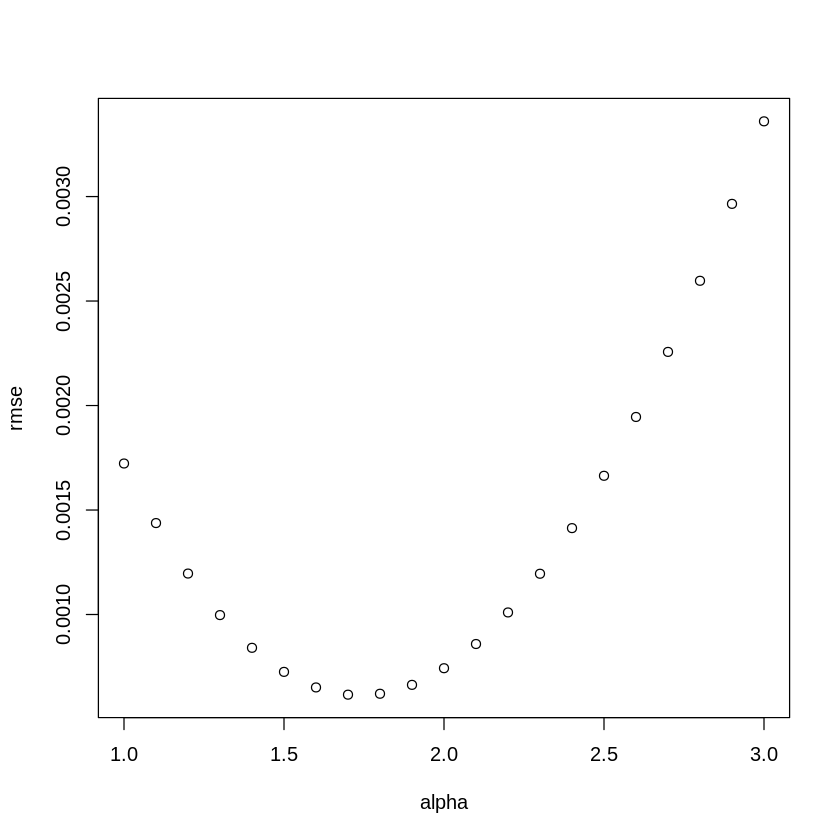

In [4]:
result <- tibble::tibble(                                                                         #
  alpha = seq(from = 1, to = 3, by = 0.1),                                                        #
  rmse = NA                                                                                       #
)                                                                                                 #

for (i in 1:nrow(result)) {                                                                       #
  result$rmse[i] <- calculate_record(game = game, alpha = result$alpha[i]) |>                     #
    with(mean((win_pct_actual - win_pct_pythag)^2))                                               #
}                                                                                                 #

alpha_min <- result |>                                                                            #
  dplyr::arrange(rmse) |>                                                                         #
  with(alpha[1])                                                                                  #

print(alpha_min)                                                                                  #

result |>                                                                                         #
  with(plot(alpha, rmse))                                                                         #

INTERLUDE

We use bootstrapping to estimate the noise variance of residual winning percentage.

In [15]:
bootstrap_data <- NULL                                                                            #
B <- 100                                                                                          #

for (b in 1:B) {                                                                                  #

  bootstrap_sample <- game |>                                                                     #
    dplyr::slice(sample(1:nrow(game), size = nrow(game), replace = TRUE)) |>                      #
    calculate_record(alpha = alpha_min) |>                                                        #
    tibble::add_column(bootstrap_sample = b, .before = 1)                                         #

  bootstrap_data <- dplyr::bind_rows(bootstrap_data, bootstrap_sample)                            #
}                                                                                                 #

# Estimate how much of the variance in residual winning percentage is noise                       #
var_residual_noise <- bootstrap_data |>                                                           #
  dplyr::group_by(season, team_id, team_name) |>                                                  #
  dplyr::summarize(var_residual_noise = var(win_pct_residual), .groups = "drop") |>               #
  dplyr::summarize(var_residual_noise = mean(var_residual_noise), .groups = "drop") |>            #
  # We are calculating the noise variance for a full season, i.e. sigma^2_Z / 162.                #
  # To get sigma^2_Z, we multiply by 162.                                                         #
  with(162 * var_residual_noise)                                                                  #

var_residual_noise    # This is sigma^2_Z                                                         #

[1] 0.09626689

EXERCISE #5

Estimate $\sigma^2_{\eta}$, the signal variance of residual winning percentage.

Use the fact that the total variance $\mbox{Var}(Y_i) = \sigma^2_{\eta} + \sigma^2_Z / n$.

In [16]:
var_residual_total <- calculate_record(game, alpha = 1.7) |>                                      #
  with(var(win_pct_residual))                                                                     #

var_residual_signal <- var_residual_total - var_residual_noise / 162                              #

var_residual_signal                                                                               #

[1] 2.705751e-05

EXERCISE #6

Calculate the sample size $n = \sigma^2_z / \sigma^2_\eta$ at which we switch from preferring Pythag winning percentage to preferring actual winning percentage.

Hint: We're looking for something that can be done in one line of code.

In [18]:
var_residual_noise / var_residual_signal                                                          #

[1] 3557.861